# Part 4: Styling with Style Sheets

We can set up style in plots one command at a time or we can load in a whole set of styles as a "style sheet" file. These files have the extension `.mplstyle` and there is a standard set that comes with *Pythonb* and you can find others on the web provided by journals or helpful people.

In the code blocks below observe, how we take a code example from Part 3C: Using LMFit and then apply different style sheets. Which do you prefer?

## Load the Toolbox

As always we start with laoding the tools.

In [124]:
### Install and load packages
 
#!pip install uncertainties              # uncomment to install dependancy
#!pip install lmfit                     ### for docs see https://lmfit.github.io/lmfit-py/

import lmfit
import numpy as np                       # import the tools of NumPy but use a shorter name, "np"
from matplotlib import pyplot as plt     # tools for plotting
import matplotlib
import scipy.constants

import uncertainties as un               # tool set for handling numbers with uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy that uses uncertainty values

### Set global variables

location_data = "data/"         ## Use either local folder or github folder. 
location_styles = "styles/"     ## Use github locations for Colab
#location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

plt.rcdefaults()


###

## Perform the Curve Fit

In the code below we start with the experimental results and then construct an array of ufloat values for the rate constants, $k$. This will allow us to use the uncertainties package to properly propagate errors through the #\ln(k/T)$ term for the y-axis. We then separate the nominal and error component of the y-axis values to give the x, y and y-error values for the curve fit.

To use *LMFit* we must first create a model object using the ```lmfit.model``` function. Then we assign parameters and initial values to that model using ```lmfit.make_params```. Finally we optimize those parameters using a curve fit by calling the ```lmfit.fit``` function and assigning the bresult to a variable name.  this new variable now contains an lmfit object that contains the results and many tools for interpretting that information.

### Set Up the Data

Below we obtain the x,y and y-error values for the linear Eyring plot.

In [125]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

### The Curve Fit

Below we use the ```lmfit.fit``` function to produce an object that contains the optimized parameters and much more.

In [126]:
######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

mod = lmfit.Model(linear)                   # load the function f as the model to be fit
pars = mod.make_params(m=-1000, b=-1  )     # state the parameters (use the text strings that we 
                                            # used above in the function) initial values are also set here
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   



### Extract Results and Print Report

Now we call the ```fit_report``` function built into the result object. It will output lots of information about the fit. We then extract the slope and intercept as uncertain values and calculate the $\Delta H^\ddagger$ and $\Delta S^\ddagger$ values. Compare these to the results from ```scipy.optimize.curve_fit```. They should be identical because both systems use the least squares algorithm. You will see that the calculation of $k_{cat}$ at a given temperature produces a good value showing that the covariance between $\Delta H^\ddagger$ and $\Delta S^\ddagger$  is included in their respective ufloat values.

In [127]:
print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
#print(result.ci_report())
#print()

intercept = result.uvars['b']         ### collect parameters as uncertain values within result object
slope = result.uvars['m']

Temp = 303
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R
print("------THERMODYNAMIC PARAMETERS----------")
print(f"The change in enthalpy is {dH:0.2f} J/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")
print()
## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")



---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 8.03472275
    reduced chi-square = 2.67824092
    Akaike info crit   = 6.37167291
    Bayesian info crit = 5.59054873
    R-squared          = -7.69086731
[[Variables]]
    m: -5545.86259 +/- 277.775827 (5.01%) (init = -1000)
    b:  15.3123516 +/- 0.91797561 (6.00%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9999
RSQ = 0.994

------THERMODYNAMIC PARAMETERS----------
The change in enthalpy is 46110.87+/-2309.56 J/mole
The change in entropy is -70.24+/-7.63 J/mole.K

-------- CHECK FIT ----------
calculate k at T=303 K is 15.22+/-0.15


## Styling Examples

We can access style options within the built in plotting function of the result object. Observe how we do this using style dictionaries and style files. the example below uses the built-in plot function in the *LMFit* object. We apply styles using style sheets. In the final example I add some specific style options to get exactly my preferred style for these kinds of presentations.

You can use standard styles and then make some tweaks or you can edit a standard file to obtain your preferred style as default. Its up to you. Consider the following code.

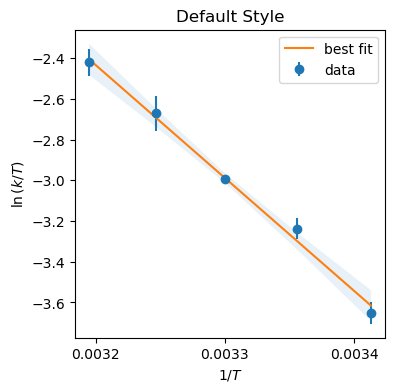

In [128]:
plt.rcdefaults()

fig = plt.figure(figsize = [4,4])
result.plot_fit(
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = "Default Style",
            )

plt.xticks([0.0032,0.0033,0.0034])  # These will be the ticks for both axes

### Confidence band
sigma = 2
dely = result.eval_uncertainty(x=x)
plt.fill_between(x, result.best_fit - sigma*dely, result.best_fit + sigma*dely, 
                   alpha = 0.1, zorder=1
                   )

fig.savefig("plots/LMfitplot2.pdf")
plt.show()

### More Styles

The above is the default style applied to my plot. We can used many other styles that are built in. Lets see what is available using the code below.

In [136]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### Examples of Style Sheets

Below is code that will run through all the available styles and output a plot for each.

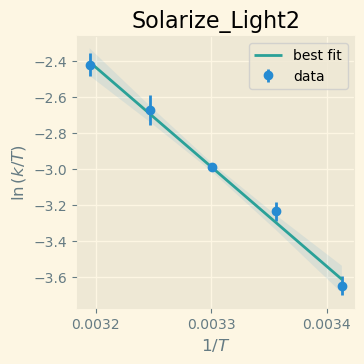

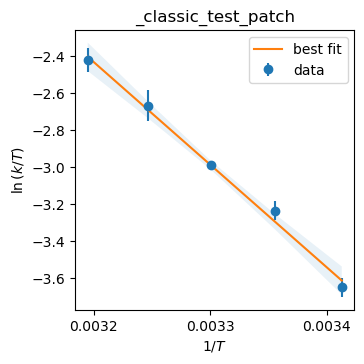

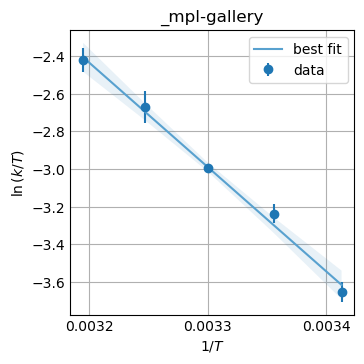

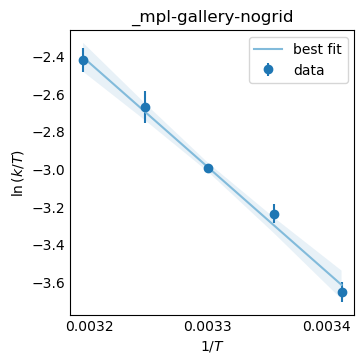

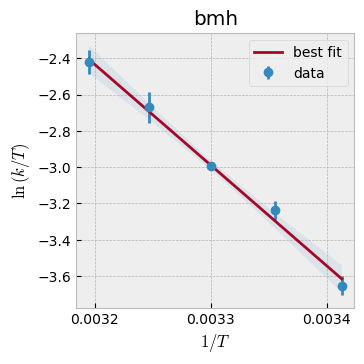

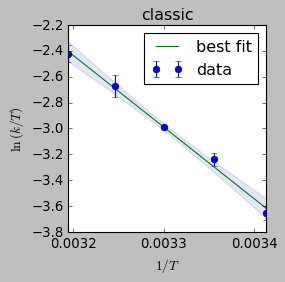

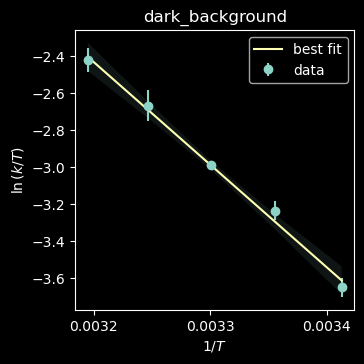

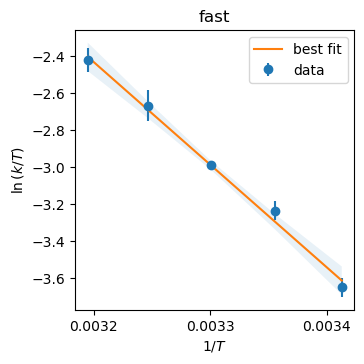

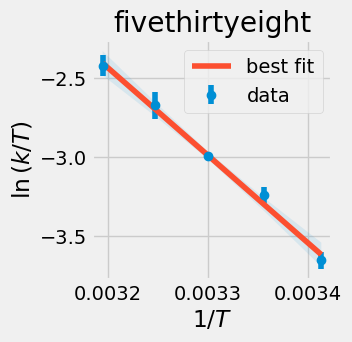

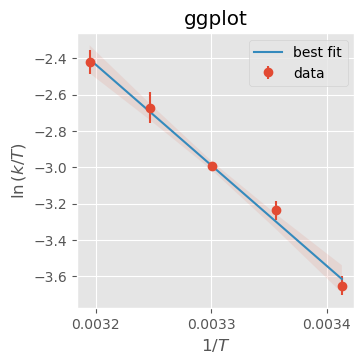

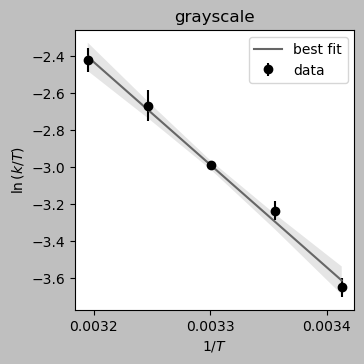

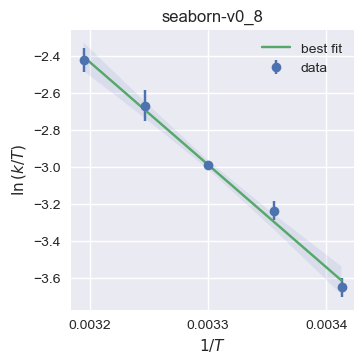

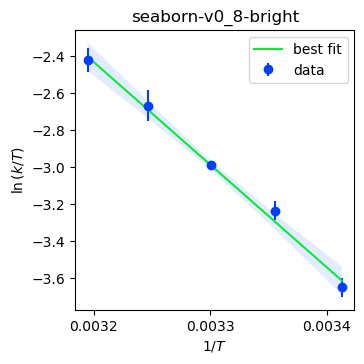

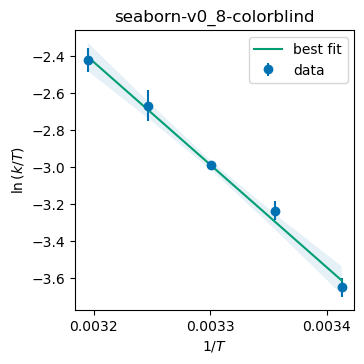

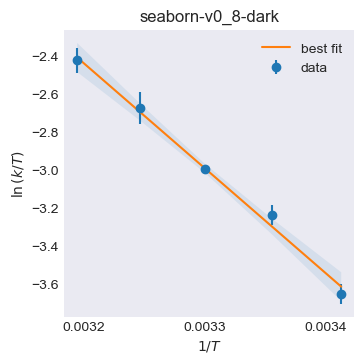

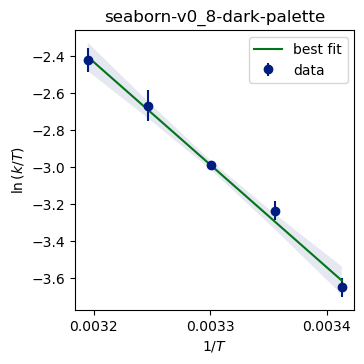

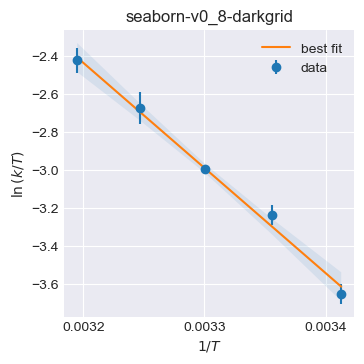

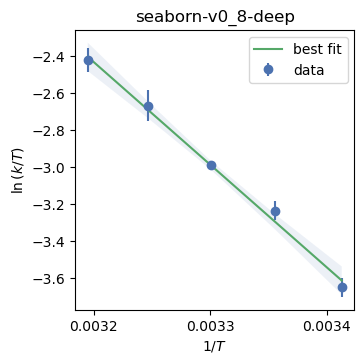

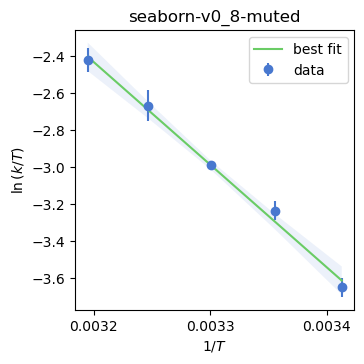

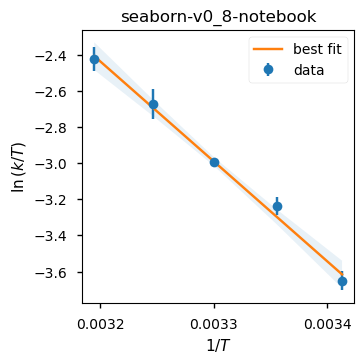

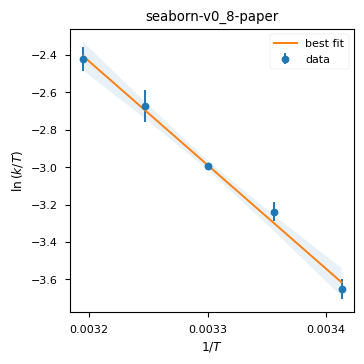

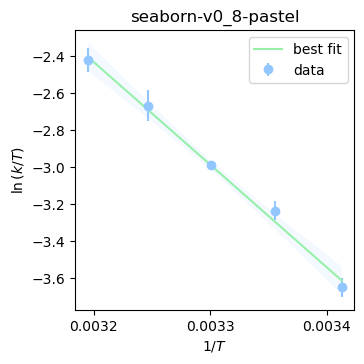

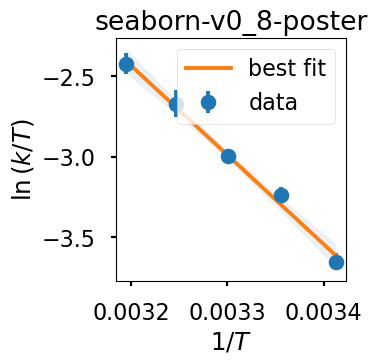

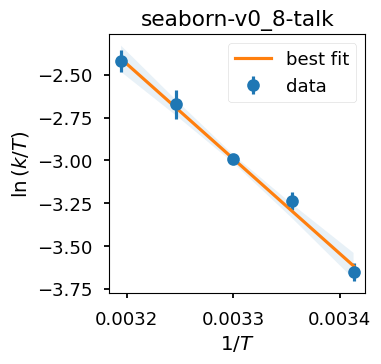

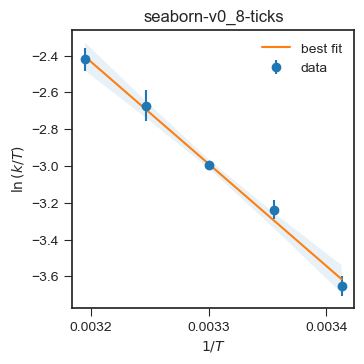

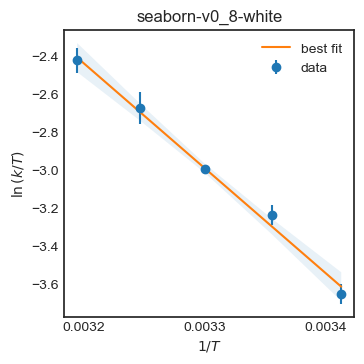

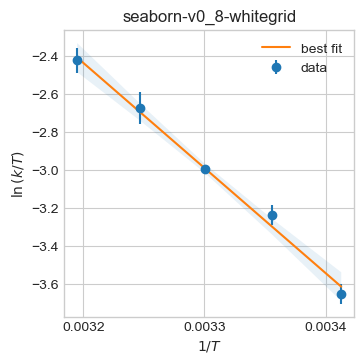

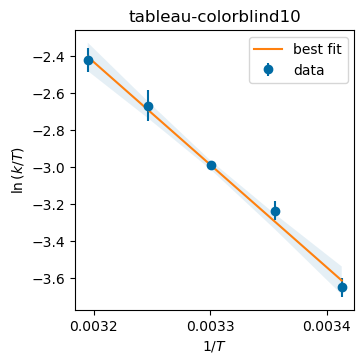

In [133]:
styles = plt.style.available

for style in styles:
    plt.rcdefaults()
    matplotlib.style.use(style)
    
    fig = plt.figure(figsize = [4,4])
    result.plot_fit(
                xlabel = r"$1/T$",
                ylabel = r"$\ln \left( k/T \right)$",
                yerr = 2*y_err,
                title = style,
                )
    
    plt.xticks([0.0032,0.0033,0.0034])  # These will be the ticks for both axes
    
    ### Confidence band
    sigma = 2
    dely = result.eval_uncertainty(x=x)
    plt.fill_between(x, result.best_fit - sigma*dely, result.best_fit + sigma*dely, 
                       alpha = 0.1, zorder=1
                       )
    plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)

    fig.savefig("plots/04style-"+style+".pdf")
    plt.show()

### My Style

You can use style sheets from others. Here I use a style sheet made by Nicole Vadot via their github site at https://github.com/ninivert/matplotlib_tufte

I downloaded the style file, made a small modification (removed the axis lines) and then saved it in my own working folder. 

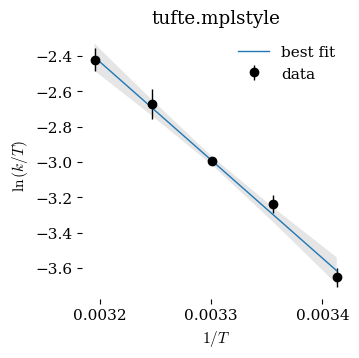

In [137]:
plt.rcdefaults()
style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig = plt.figure(figsize = [4,4])
result.plot_fit(
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = style,
            )

plt.xticks([0.0032,0.0033,0.0034])  # These will be the ticks for both axes

### Confidence band
sigma = 2
dely = result.eval_uncertainty(x=x)
plt.fill_between(x, result.best_fit - sigma*dely, result.best_fit + sigma*dely, 
                   alpha = 0.1, zorder=1
                   )
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
fig.savefig("plots/04style-"+style+".pdf")
plt.show()

### Final Tweaks

I have a preferred style that is "lighter" in appearance than the dfault colors and sizes of *matplotlib*. I could edit the style file but I often have different needs so I prefer to apply line and marker styles separately. 

here I am using keyword dictionaries to pass style commands into the *LMFit* plot command. When plotting the confidence interval I am passing the style commands as direct arguments to the plot function. Pyplot has many ways to send style information to the polotting system and different modules demand different paradigms. Once you figure it all out just keep copying that code and reusing and you'll never have to relearn it. 

Consider the code below.

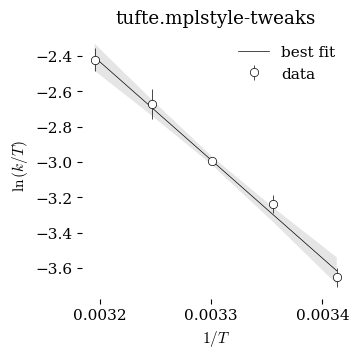

In [145]:
plt.rcdefaults()
style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig = plt.figure(figsize = [4,4])
result.plot_fit(xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = style+"-tweaks",
            data_kws ={"color":"k", 
                       "linestyle":"None", 
                       "linewidth": 0.5,
                       "markerfacecolor": "white",
                       "markeredgecolor":"black", 
                       "markeredgewidth":0.5, 
                       "zorder":3},
            fit_kws ={"linewidth": 0.5, 
                      "zorder":2},
            )

plt.xticks([0.0032,0.0033,0.0034])  # These will be the ticks for both axes

### Confidence band
sigma = 2
dely = result.eval_uncertainty(x=x)
plt.fill_between(x, result.best_fit - sigma*dely, result.best_fit + sigma*dely, 
                   edgecolor = "none", facecolor = "black",
                   alpha = 0.1, zorder=1
                   )
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
fig.savefig("plots/04style-"+style+"-tweaks.pdf")
plt.show()